# COURSE: A deep understanding of deep learning
## SECTION: Measuring model performance
### LECTURE: APRF example 1: wine quality
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202210

In [14]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\lucan\AppData\Local\Temp\ipykernel_7660\1348730236.py:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Import and process the data

In [15]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>5] = 1

C:\Users\lucan\AppData\Local\Temp\ipykernel_7660\789887509.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality']>5] = 1


In [16]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None] # transform to matrix

# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = torch.utils.data.TensorDataset(train_data,train_labels)
test_dataDataset  = torch.utils.data.TensorDataset(test_data,test_labels)

# finally, create dataloaders
train_loader = DataLoader(train_dataDataset,batch_size=32, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

# Now for the DL part

In [17]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self, weight_init_method: str):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)
    
    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)

    for p in self.named_parameters():
      if 'weight' in p[0]:
        if weight_init_method == "Kaiming":
          nn.init.kaiming_normal_(p[1].data, nonlinearity='relu')
        elif weight_init_method == "Xavier":
          nn.init.xavier_normal_(p[1].data)
        else:
          print(f"UNKNOWN WEIGHT INIT METHOD: {weight_init_method}. USING DEFAULT!")
  
  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = F.relu( self.fc2(x) )
    return self.output(x)

# A function to train the model

In [18]:
# global parameter
numepochs = 200

def trainTheModel(winenet):

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(winenet.parameters(), lr=.001)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
  
  # function output
  return trainAcc,testAcc,losses

# Now to create the fitted model

In [19]:
# create and test the models
winenet = ANNwine("Xavier")
winenet(train_loader.dataset.tensors[0])

winenet = ANNwine("Kaiming")
winenet(train_loader.dataset.tensors[0])

tensor([[0.5687],
        [2.2898],
        [0.8763],
        ...,
        [1.5327],
        [1.3219],
        [0.3249]], grad_fn=<AddmmBackward0>)

# Compute the performance measures on the train and test data

In [20]:
from time import perf_counter

# Run experiments
repeats = 10
methods = ["Xavier", "Kaiming"]

train_accuracies  = np.zeros((len(methods), repeats, numepochs))
test_accuracies   = np.zeros((len(methods), repeats, numepochs))
Losses            = np.zeros((len(methods), repeats, numepochs))

for m_idx, method in enumerate(methods):
  for i in range(repeats):
    start = perf_counter()

    winenet = ANNwine(method)
    trainAcc,testAcc,loss = trainTheModel(winenet)

    train_accuracies[m_idx, i, :] = trainAcc
    test_accuracies[m_idx, i, :] = testAcc
    Losses[m_idx, i, :] = loss

    timediff = perf_counter() - start
    print(f"Finished [{method}-{i}] in [{timediff:.2f}s] with [{testAcc[-1]:.2f}%] accuracy")

Finished [Xavier-0] in [14.56s] with [80.00%] accuracy
Finished [Xavier-1] in [14.60s] with [81.88%] accuracy
Finished [Xavier-2] in [14.41s] with [76.25%] accuracy
Finished [Xavier-3] in [14.67s] with [76.25%] accuracy
Finished [Xavier-4] in [15.14s] with [82.50%] accuracy
Finished [Xavier-5] in [14.68s] with [75.00%] accuracy
Finished [Xavier-6] in [14.99s] with [77.50%] accuracy
Finished [Xavier-7] in [14.71s] with [78.75%] accuracy
Finished [Xavier-8] in [13.58s] with [75.00%] accuracy
Finished [Xavier-9] in [12.49s] with [76.25%] accuracy
Finished [Kaiming-0] in [12.55s] with [79.37%] accuracy
Finished [Kaiming-1] in [12.52s] with [81.88%] accuracy
Finished [Kaiming-2] in [14.09s] with [82.50%] accuracy
Finished [Kaiming-3] in [13.66s] with [76.88%] accuracy
Finished [Kaiming-4] in [13.60s] with [79.37%] accuracy
Finished [Kaiming-5] in [14.36s] with [76.88%] accuracy
Finished [Kaiming-6] in [14.17s] with [81.25%] accuracy
Finished [Kaiming-7] in [12.96s] with [76.88%] accuracy
Fi

# Visualize the data

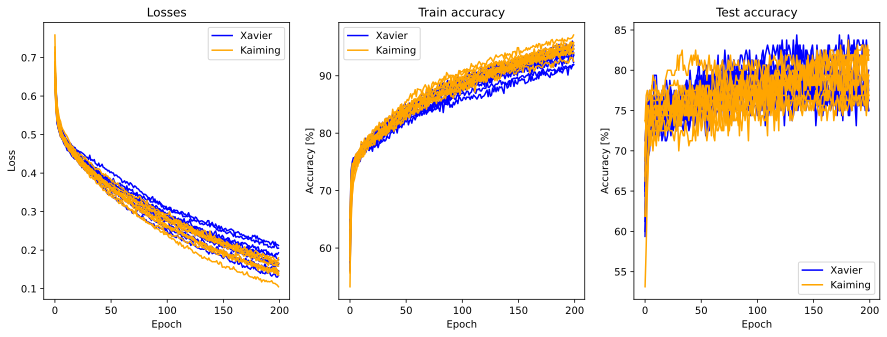

In [21]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.title("Losses")
plt.plot(Losses[0, :, :].T, label=[methods[0]] + [None] * (repeats-1), color="Blue")
plt.plot(Losses[1, :, :].T, label=[methods[1]] + [None] * (repeats-1), color="Orange")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(132)
plt.title("Train accuracy")
plt.plot(train_accuracies[0, :, :].T, label=[methods[0]] + [None] * (repeats-1), color="Blue")
plt.plot(train_accuracies[1, :, :].T, label=[methods[1]] + [None] * (repeats-1), color="Orange")
plt.ylabel("Accuracy [%]")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(133)
plt.title("Test accuracy")
plt.plot(test_accuracies[0, :, :].T, label=[methods[0]] + [None] * (repeats-1), color="Blue")
plt.plot(test_accuracies[1, :, :].T, label=[methods[1]] + [None] * (repeats-1), color="Orange")
plt.ylabel("Accuracy [%]")
plt.xlabel("Epoch")
plt.legend()

plt.show()

# Statistical analysis

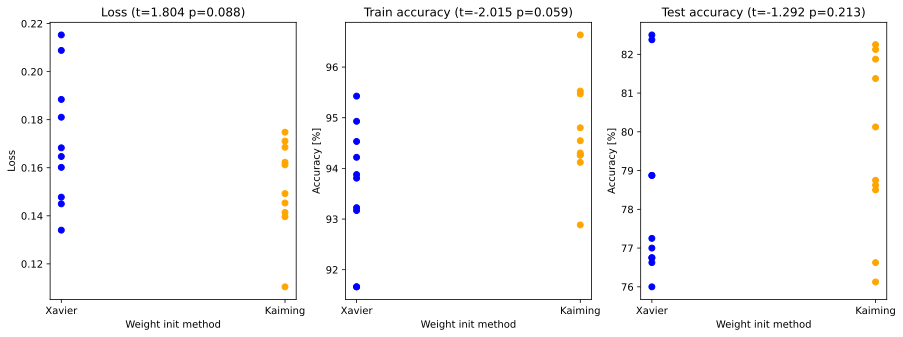

In [22]:
final_losses = np.mean(Losses[:,:,-5:], axis=2)
final_test_accuracy = np.mean(test_accuracies[:,:,-5:], axis=2)
final_train_accuracy = np.mean(train_accuracies[:,:,-5:], axis=2)

plt.figure(figsize=(15, 5))

plt.subplot(131)
t, p = stats.ttest_ind(final_losses[0], final_losses[1])
plt.scatter(np.tile(methods, repeats), final_losses.T, color=np.tile(["Blue", "Orange"], repeats))
plt.title(f"Loss (t={t:.3f} p={p:.3f})")
plt.xlabel("Weight init method")
plt.ylabel("Loss")

plt.subplot(132)
t, p = stats.ttest_ind(final_train_accuracy[0], final_train_accuracy[1])
plt.scatter(np.tile(methods, repeats), final_train_accuracy.T, color=np.tile(["Blue", "Orange"], repeats))
plt.title(f"Train accuracy (t={t:.3f} p={p:.3f})")
plt.xlabel("Weight init method")
plt.ylabel("Accuracy [%]")

plt.subplot(133)
t, p = stats.ttest_ind(final_test_accuracy[0], final_test_accuracy[1])
plt.scatter(np.tile(methods, repeats), final_test_accuracy.T, color=np.tile(["Blue", "Orange"], repeats))
plt.title(f"Test accuracy (t={t:.3f} p={p:.3f})")
plt.xlabel("Weight init method")
plt.ylabel("Accuracy [%]")

plt.show()
